## Working with text data

Text data represents a feature rich, expert annotated data source that can be used to generate high performance models. However, unlike the previously structed data used, text is stored as unstructured data. This poses a challenge when trying to leverage information in text to build machine learning models. Natural language processing (NLP) is an interdisciplinary field focused on processing text data using computers. Leveraging techniques from NLP, we can convert textual data into a format consumable by models. 

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer
import json
import sys
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ggray15/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def Blob2Words(TextBlob):
    TextBlob = TextBlob.split(' ')
    words = [w for w in TextBlob if w.isalpha()]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('not')
    words = [w for w in words if w.lower() not in stopwords]
    return words

def remove_stopwords(word_list):
    filtered_list = list()
    stop_words = nltk.corpus.stopwords.words('english')
    for word in word_list:
        if word.casefold() not in stop_words:
            filtered_list.append(word.lower())
    return filtered_list

def stem_words(word_list):
    filtered_list = list()
    stemmer = PorterStemmer()
    for word in word_list:
        filtered_list.append(stemmer.stem(word))
    return filtered_list

In [4]:
os_platform = sys.platform

if os_platform == 'windows':
    RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
else:
    RootDir = '/'.join(os.getcwd().split('/')[0:-2])
os.chdir(RootDir)

In [5]:
%run "./notebooks/common/function_library.ipynb"

In [6]:
target_df = pd.read_csv('data/labels.csv')

In [7]:
df_list = list()
for id in range(10):
    df_i = pd.read_csv('data/noteevents_{id}.csv.gz'.format(id=id),compression='gzip')
    df_list.append(df_i)
notes_df = pd.concat(df_list)
notes_df.reset_index(inplace=True,drop=True)
notes_df

,Unnamed: 0,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,text
0,0,26064,174507,2174-12-11 00:00:00.000,2174-12-11 07:21:00.000,2174-12-11 07:22:00.000,Nursing/other,Report,15938.0,"[** 63**] PHysical Exam\nPE: pinkk AFOF, breat..."
1,1,26064,174507,2174-12-11 00:00:00.000,2174-12-11 09:11:00.000,2174-12-11 09:18:00.000,Nursing/other,Report,18056.0,"Neonatology Attending Note\nDOL# 13, CGA 31 [*..."
2,2,26064,174507,2174-12-26 00:00:00.000,2174-12-26 08:57:00.000,2174-12-26 09:07:00.000,Nursing/other,Report,19591.0,NP NOTE\nPE: small growing preterm infant nest...
3,3,26064,174507,2174-12-26 00:00:00.000,2174-12-26 09:39:00.000,2174-12-26 09:48:00.000,Nursing/other,Report,21222.0,Attending Note\nDay of life 28 PMA 33 [**2-21*...
4,4,26064,174507,2175-01-15 00:00:00.000,2175-01-15 16:49:00.000,2175-01-15 16:56:00.000,Nursing/other,Report,17101.0,NPN DAYS\n\n\nResp: Baby breathing comfortably...
...,...,...,...,...,...,...,...,...,...,...
406268,406268,795,184041,2146-07-01 00:00:00.000,2146-07-01 02:29:00.000,2146-07-01 02:33:00.000,Nursing/other,Report,14872.0,NPN 1900-0700\n\n\n1. RESP: O: Pt remains i...
406269,406269,795,184041,2146-07-01 00:00:00.000,2146-07-01 09:09:00.000,2146-07-01 09:09:00.000,Nursing/other,Report,16523.0,Neonatal NP-Exam\n\nSee Dr.[**Name (NI) 1635**...
406270,406270,795,184041,2146-07-01 00:00:00.000,2146-07-01 09:34:00.000,2146-07-01 09:36:00.000,Nursing/other,Report,20898.0,Neonatology attending note\n4 d.o\nresp: in RA...
406271,406271,795,184041,2146-07-01 00:00:00.000,2146-07-01 15:11:00.000,2146-07-01 15:16:00.000,Nursing/other,Report,18920.0,NPN 0700-1900\n\n\n1. O: Ls clear. O2 sats>94%...


In [8]:
text_df = pd.merge(target_df,notes_df,how='left',on=['hadm_id']).drop(columns=['subject_id_y']).rename(columns={'subject_id_x':'subject_id'}).sort_values(['subject_id','hadm_id','chartdate'])
text_df['note_time_before_dicharge'] = text_df['dischtime'].astype('datetime64[ns]') - text_df['charttime'].astype('datetime64[ns]')
text_df = text_df[(text_df['note_time_before_dicharge'] >= pd.to_timedelta(1,'D')) & (text_df['note_time_before_dicharge'] <= pd.to_timedelta(2,'D'))]
text_df.reset_index(inplace=True,drop=True)
text_df

,subject_id,subject_id.1,hadm_id,readmit_flag,dischtime,Unnamed: 0,chartdate,charttime,storetime,category,description,cgid,text,note_time_before_dicharge
0,10,10.0,184167,0,2103-07-06 12:10:00.000,370085.0,2103-07-04 00:00:00.000,2103-07-04 16:57:00.000,2103-07-04 17:01:00.000,Nursing/other,Report,14968.0,NPN 0700-[**2030**]\n\n\n1. Mother called and...,1 days 19:13:00
1,10,10.0,184167,0,2103-07-06 12:10:00.000,370086.0,2103-07-04 00:00:00.000,2103-07-04 18:32:00.000,2103-07-04 18:35:00.000,Nursing/other,Report,14968.0,NPN addendum\n[**2-19**]. Dstick down to 47 a...,1 days 17:38:00
2,10,10.0,184167,0,2103-07-06 12:10:00.000,370087.0,2103-07-04 00:00:00.000,2103-07-04 22:00:00.000,2103-07-04 22:01:00.000,Nursing/other,Report,16123.0,Rehab/OT\n\n[** **] observed today during care...,1 days 14:10:00
3,10,10.0,184167,0,2103-07-06 12:10:00.000,370078.0,2103-07-05 00:00:00.000,2103-07-05 11:51:00.000,2103-07-05 11:52:00.000,Nursing/other,Report,18232.0,"Neonatology fellow note\nSleeping, NAD\nAFOF, ...",1 days 00:19:00
4,10,10.0,184167,0,2103-07-06 12:10:00.000,370088.0,2103-07-05 00:00:00.000,2103-07-05 03:24:00.000,2103-07-05 03:31:00.000,Nursing/other,Report,17679.0,NPN 1900-0700\n\n\n#1Parenting. O: [** **] her...,1 days 08:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19084,32806,32806.0,104049,0,2162-11-03 13:50:00.000,251278.0,2162-11-02 00:00:00.000,2162-11-02 02:05:00.000,2162-11-02 06:56:00.000,Nursing/other,Report,20296.0,PCA Progress Note 1900-0700\nI have examined B...,1 days 11:45:00
19085,32806,32806.0,104049,0,2162-11-03 13:50:00.000,251279.0,2162-11-02 00:00:00.000,2162-11-02 12:07:00.000,2162-11-02 12:11:00.000,Nursing/other,Report,21222.0,Attending Note\nDay of life 11 PMA 35 [**2-7**...,1 days 01:43:00
19086,32806,32806.0,104049,0,2162-11-03 13:50:00.000,251280.0,2162-11-02 00:00:00.000,2162-11-02 13:09:00.000,2162-11-02 13:27:00.000,Nursing/other,Report,14461.0,1. FEN\nTF= min140cc/k/d of BM/E24. min47cc q4...,1 days 00:41:00
19087,32806,32806.0,104049,0,2162-11-03 13:50:00.000,251301.0,2162-11-02 00:00:00.000,2162-11-02 02:05:00.000,2162-11-02 02:12:00.000,Nursing/other,Report,18485.0,PCA Progress Note 1900-0700\n\n\nRESP O/A: Inf...,1 days 11:45:00


In [9]:
text_group_df = text_df.groupby('hadm_id', as_index=False).agg({'text': ' '.join,'readmit_flag':'max'})
text_group_df

,hadm_id,text,readmit_flag
0,100025,1 Fluid and Nutrition\n2 Alt in Parenting\n3 A...,0
1,100029,NPN [**6-/2082**]\n\n\n\n #3 [**Doctor First N...,0
2,100044,Neonatology Attending\nDay 31\nPCA 39 5\n\nRA....,0
3,100062,NURSING PROGRESS NOTE\n\n\n2 - FEN - BABY BREA...,0
4,100079,Admission Note\nOB- [**First Name8 (NamePatter...,0
...,...,...,...
4479,199901,Neonatology\nDoing well. REmains in RA. No spe...,0
4480,199913,"NPN 07a-07p\n\n\nFEN\nTF 150cc/kg/day, BM/Neos...",0
4481,199917,Nursing Progress Note\n\n\n#1-O/A- Received i...,0
4482,199918,"PCA Note:\n\n\nResp: O: Infant in RA, SaO2 wit...",0


In [10]:
input_df = text_group_df

In [11]:
input_df['text_tokenized'] = input_df['text'].apply(lambda x: Blob2Words(x))
input_df['text_remove_stop'] = input_df['text_tokenized'].apply(lambda x: remove_stopwords(x))
input_df['text_stem'] = input_df['text_remove_stop'].apply(lambda x: stem_words(x))
input_df['text_cleaned'] = input_df['text_stem'] .apply(lambda x: ' '.join(x)) 
input_df

,hadm_id,text,readmit_flag,text_tokenized,text_remove_stop,text_stem,text_cleaned
0,100025,1 Fluid and Nutrition\n2 Alt in Parenting\n3 A...,0,"[Fluid, Alt, Alt, Fluid, Start, Alt, Start, Al...","[fluid, alt, alt, fluid, start, alt, start, al...","[fluid, alt, alt, fluid, start, alt, start, al...",fluid alt alt fluid start alt start alt start ...
1,100029,NPN [**6-/2082**]\n\n\n\n #3 [**Doctor First N...,0,"[NPN, First, Name, CHANGED, MIN, TAKING, BOTTL...","[npn, first, name, changed, min, taking, bottl...","[npn, first, name, chang, min, take, bottl, ab...",npn first name chang min take bottl abd soft s...
2,100044,Neonatology Attending\nDay 31\nPCA 39 5\n\nRA....,0,"[Neonatology, Cl, days, HR, BP, Wt, PO, ad, li...","[neonatology, cl, days, hr, bp, wt, po, ad, li...","[neonatolog, cl, day, hr, bp, wt, po, ad, lib,...",neonatolog cl day hr bp wt po ad lib tol nl vo...
3,100062,NURSING PROGRESS NOTE\n\n\n2 - FEN - BABY BREA...,0,"[NURSING, PROGRESS, FEN, BABY, BREAST, FEEDING...","[nursing, progress, fen, baby, breast, feeding...","[nurs, progress, fen, babi, breast, feed, ad, ...",nurs progress fen babi breast feed ad lib abd ...
4,100079,Admission Note\nOB- [**First Name8 (NamePatter...,0,"[Admission, Name, see, baby, boy, sepsis, gram...","[admission, name, see, baby, boy, sepsis, gram...","[admiss, name, see, babi, boy, sepsi, gram, pr...",admiss name see babi boy sepsi gram product te...
...,...,...,...,...,...,...,...
4479,199901,Neonatology\nDoing well. REmains in RA. No spe...,0,"[REmains, Comfortable, Tolerating, feeds, Abdo...","[remains, comfortable, tolerating, feeds, abdo...","[remain, comfort, toler, feed, abdomend, take,...",remain comfort toler feed abdomend take ad lib...
4480,199913,"NPN 07a-07p\n\n\nFEN\nTF 150cc/kg/day, BM/Neos...",0,"[NPN, Tolerating, Bottled, shift, thus, end, B...","[npn, tolerating, bottled, shift, thus, end, b...","[npn, toler, bottl, shift, thu, end, bs, stool...",npn toler bottl shift thu end bs stool shift t...
4481,199917,Nursing Progress Note\n\n\n#1-O/A- Received i...,0,"[Nursing, Progress, Received, infant, Tried, i...","[nursing, progress, received, infant, tried, i...","[nurs, progress, receiv, infant, tri, infant, ...",nurs progress receiv infant tri infant sat con...
4482,199918,"PCA Note:\n\n\nResp: O: Infant in RA, SaO2 wit...",0,"[PCA, Infant, within, limits, mild, SC, spells...","[pca, infant, within, limits, mild, sc, spells...","[pca, infant, within, limit, mild, sc, spell, ...",pca infant within limit mild sc spell thu infa...


In [12]:
train_df, test_df = train_test_split(input_df[['text_cleaned','readmit_flag']],test_size=0.4,random_state=42, stratify=input_df['readmit_flag'].tolist())

### Term frequency inverse document frequency 

Now that we have clean text, we need to convert the strings in the data to a numerical value that can be leveraged by a model. There are multiple approaches to this, but one common method is term frequency inverse document frequency (tfidf). Term frequency refers to the frequency with which a term appears in the document. While some might consider this a sufficient measure, it overweights common words that may not provide much insight, while effectively losing uncommon (but potentially important) words in the noise. This problem can be mitigated to some degree by incorporating the inverse document frequency. Thus, contributions of common words with high frequency will be reduced by the inverse weight of a large number of documents. 

The formula for tfidf is:

tf-idf(t, d) = tf(t, d) * idf(t)

Where tf(t, d) is the document frequency.

idf(t) = log [ n / df(t) ] + 1

where n is the total number of documents in the document set and df(t) is the document frequency of t

For more information see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

In [13]:
vectorizer = TfidfVectorizer(min_df = 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
feature_selector = SelectKBest(chi2, k=1200)

In [14]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',classes = np.unique(train_df['readmit_flag'].values), y=train_df['readmit_flag'].values)

In [15]:
class_weight_dict = dict(zip(np.unique(train_df['readmit_flag'].values),class_weights))
class_weight_dict

{0: 0.5123809523809524, 1: 20.692307692307693}

In [16]:
param_files = [
    'lr_params.json',
    'knn_params.json',
    'svm_params.json',
    'mlp_params.json',
    'rf_params.json',
    'gb_params.json',
]

param_dict = dict()

for iFile in param_files:
    iKey = iFile.split('_')[0]
    with open(os.path.join('input',iFile),'r') as f:
        params = json.load(f)
        param_dict_temp = BuildSamplingDict(params)
        
        param_dict[iKey] = dict()
        for jKey in param_dict_temp:
            param_dict[iKey]['est__'+jKey] = param_dict_temp[jKey]
        

In [17]:
estimator_dict = {
    'lr': LogisticRegression(max_iter=1000),
    'knn': KNeighborsClassifier(algorithm='auto'),
    'svm': SVC(probability=True),
    'mlp': MLPClassifier(max_iter=1000, early_stopping=True),
    'rf': RandomForestClassifier(class_weight=class_weight_dict),
    'gb': GradientBoostingClassifier()
}

In [18]:
pipeline_dict = {}

for iKey in estimator_dict:

    pipeline = Pipeline(
        [
            ('tfidf', vectorizer),
            ('feature_selector', feature_selector),
            ('est', estimator_dict[iKey])
        ]
    )

    pipeline_dict[iKey] = pipeline

In [19]:
model_dict = dict()

for iKey in estimator_dict:

    if iKey == 'knn':
        continue

    print(f'##### Now processing model {iKey} #####')

    model_dict[iKey] = TuneHyperParameters(
        X_train=train_df['text_cleaned'], y_train=train_df['readmit_flag'], estimator= pipeline_dict[iKey],param_dict=param_dict[iKey], metric='f1', n_iter=25)
    
    test_score = EvaluateModel(X_test=test_df['text_cleaned'],y_test=test_df['readmit_flag'],estimator=model_dict[iKey])
    print(f'  > Test score was {test_score}')   

##### Now processing model lr #####
  > Test score was 0.0
##### Now processing model svm #####
  > Test score was 0.08163265306122448
##### Now processing model mlp #####


/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  > Test score was 0.03571428571428571
##### Now processing model rf #####
  > Test score was 0.12800000000000003
##### Now processing model gb #####
  > Test score was 0.1020408163265306


##### Now processing model lr #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

Accuracy: 0.9760312151616499
F1 Score: 0.0
AUC: 0.7230552641015765
Precision: 0.0
Recall: 0.0
logloss: 0.863922572871816
PPV: nan
NPV: 0.9760312151616499
True Negative: 1751
False Positive: 0
False Negative: 43
True Positive: 0
##### Now processing model svm #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9498327759197325
F1 Score: 0.08163265306122448
AUC: 0.6121286175341665
Precision: 0.07272727272727272
Recall: 0.09302325581395349
logloss: 1.8082100362433355
PPV: 0.07272727272727272
NPV: 0.9775733179988499
True Negative: 1700
False Positive: 51
False Negative: 39
True Positive: 4
##### Now processing model mlp #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9698996655518395
F1 Score: 0.03571428571428571
AUC: 0.6538589244684101
Precision: 0.07692307692307693
Recall: 0.023255813953488372
logloss: 1.0849260217460013
PPV: 0.07692307692307693
NPV: 0.9764177428411005
True Negative: 1739
False Positive: 12
False Negative: 42
True Positive: 1
##### Now processing model rf #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9392419175027871
F1 Score: 0.12800000000000003
AUC: 0.6752420543742446
Precision: 0.0975609756097561
Recall: 0.18604651162790697
logloss: 2.1899432661169285
PPV: 0.0975609756097561
NPV: 0.9795560747663551
True Negative: 1677
False Positive: 74
False Negative: 35
True Positive: 8
##### Now processing model gb #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9509476031215162
F1 Score: 0.1020408163265306
AUC: 0.5420025766007465
Precision: 0.09090909090909091
Recall: 0.11627906976744186
logloss: 1.7680275909934837
PPV: 0.09090909090909091
NPV: 0.9781483611270846
True Negative: 1701
False Positive: 50
False Negative: 38
True Positive: 5


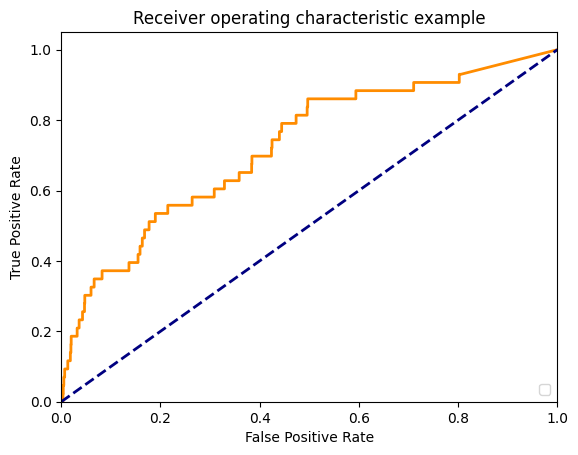

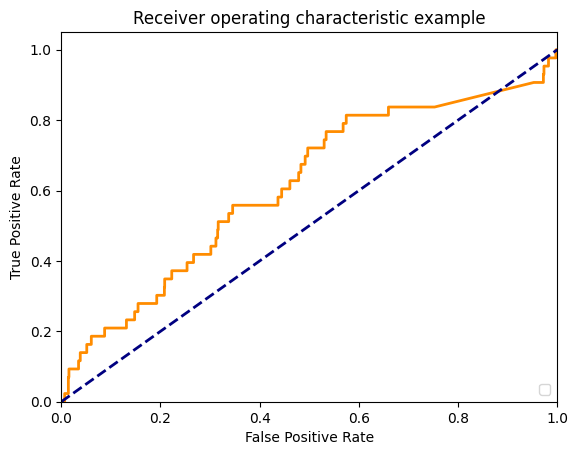

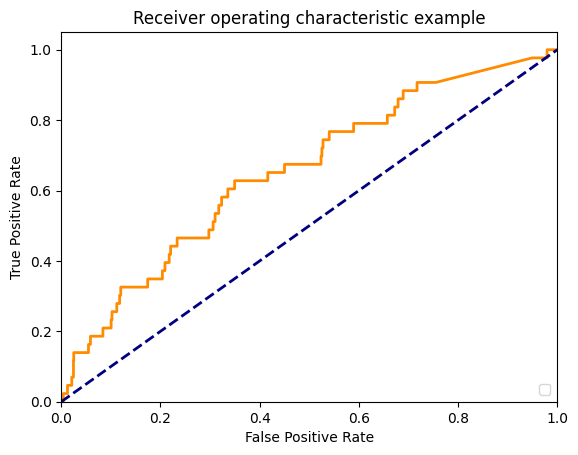

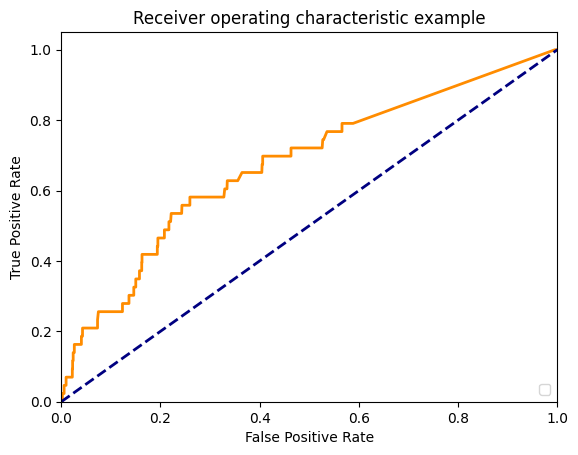

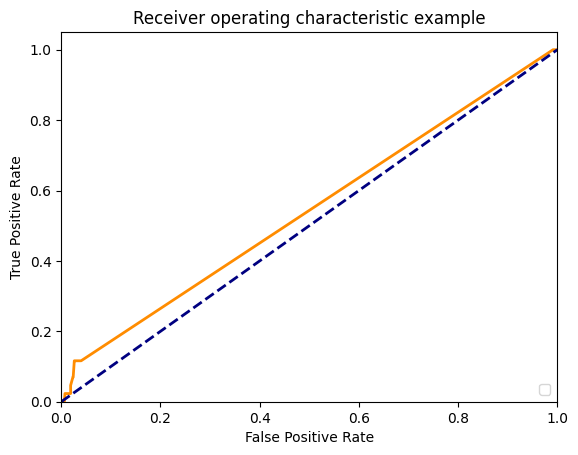

In [20]:
for iKey in model_dict:

    print(f'##### Now processing model {iKey} #####')
    LogMetrics(model_dict[iKey],test_df['text_cleaned'], test_df['readmit_flag'])

In [21]:
with open('input/xgb_params.json','r') as f:
    param_dict = json.load(f)

pipeline_param_dict = dict()
for iKey in param_dict:
    pipeline_param_dict['est__'+iKey] = param_dict[iKey]

pipeline_param_dict = BuildSamplingDict(pipeline_param_dict)

In [56]:
scale_weight = class_weight_dict[1] / class_weight_dict[0]

In [57]:
pipeline = Pipeline(
    [
        ('tfidf', vectorizer),
        ('feature_selector', feature_selector),
        ('est', XGBClassifier(scale_pos_weight=scale_weight))
    ]
)


In [58]:
xgb_opt = TuneHyperParameters(
    X_train=train_df['text_cleaned'], y_train=train_df['readmit_flag'], estimator=pipeline, param_dict=pipeline_param_dict, metric='f1', n_iter=100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9565217391304348
F1 Score: 0.04878048780487805
AUC: 0.6030441076859735
Precision: 0.05128205128205128
Recall: 0.046511627906976744
logloss: 1.5671153647442242
PPV: 0.05128205128205128
NPV: 0.9766381766381766
True Negative: 1714
False Positive: 37
False Negative: 41
True Positive: 2


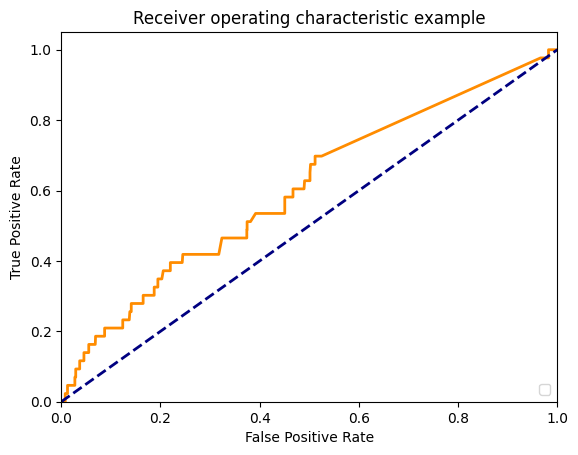

In [59]:
LogMetrics(xgb_opt, test_df['text_cleaned'], test_df['readmit_flag'])